In [1]:
## Bring in needed mods
import pandas as pd, numpy as np

## Load in matplot lib
from matplotlib import pyplot as plt

## Set random seed
np.random.seed(711)

In [2]:
## Load in sims
import mystatslib as sims

## Load in mod
import epigenomevisulization as epv

In [3]:
## Set path to cell line information
cellinfo = pd.read_csv('../DATA/H3K27ac_Cellline_info.csv')

## show the head of the df
cellinfo.head()

,Cellline,Replicate1,Replicate2
0,22Rv1,ENCFF296OMI,ENCFF434UTC
1,C4-2B,ENCFF593VYY,ENCFF474LGV
2,HL-60,ENCFF896NMH,ENCFF363VMR
3,NCI-H929,ENCFF627SMP,ENCFF581PPG
4,RWPE1,ENCFF806MCZ,ENCFF408GVF


In [4]:
## Make a paired dictonary of replicates
rep1 = cellinfo.Replicate1.tolist()
rep2 = cellinfo.Replicate2.tolist()

## Append the replicates pair wise 
repa = rep1 + rep2
repz = rep2 + rep1

## Make a dictionary of replicates
repdict = dict(zip(repa,repz))

## Check that the rep dictionary returns its self 
repdict[repdict['ENCFF296OMI']]

'ENCFF296OMI'

In [5]:
## Set a list of autosomes and sex chromosomes we are interested in
chrlist = ['chr%s'%(int(i+1)) for i in range(22)] + ['chrX','chrY']

## Check that we have twenty-four
assert len(chrlist) == 24, "We are missing chromosomes!"

In [6]:
## Set path to input H3K27ac data
H3K27ac_path = '../DATA/BEDS/H3K27ac.ceil.counts.genomic.10000.counts.bed.gz'

## Load in the dataframe 
h3k27ac = epv.loaddf(H3K27ac_path)

## Parse only the chroms of interest
h3k27ac = h3k27ac[(h3k27ac.Chrom.isin(chrlist))]

## View the head
h3k27ac.head()

,Chrom,Left,Right,ENCFF296OMI,ENCFF434UTC,ENCFF474LGV,ENCFF593VYY,ENCFF363VMR,ENCFF896NMH,ENCFF581PPG,...,ENCFF191AEE,ENCFF800SRX,ENCFF858VHX,ENCFF936CKN,ENCFF264EZF,ENCFF364AIR,ENCFF613MAH,ENCFF967YSF,ENCFF417QIX,ENCFF635LGT
0,chr1,1,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr1,10001,20000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,chr1,20001,30000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr1,30001,40000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,chr1,40001,50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
## Gather the smaples 
samples = epv.getsamples(h3k27ac)

## Print the first 5 names and number of samples
samples[:5], len(samples)

(['ENCFF296OMI', 'ENCFF434UTC', 'ENCFF474LGV', 'ENCFF593VYY', 'ENCFF363VMR'],
 20)

In [8]:
## Show the change in norm. mutual. info.
x,y = h3k27ac[samples[0]].values,h3k27ac[samples[1]].values

## Print the values 
sims.conmi(x,y,cozero=False), sims.conmi(x,y,cozero=True)

(0.8207028656446895, 0.6089360449225468)

In [9]:
## Show the change in R2
sims.copearson(x,y,cozero=False)**2, sims.copearson(x,y,cozero=True)**2

(0.8882919124263821, 0.8427319676171693)

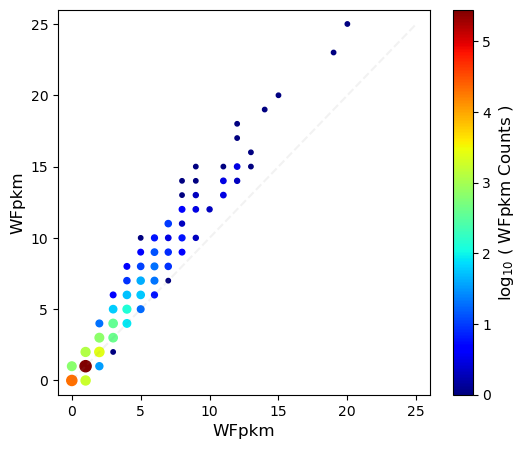

In [10]:
## Plot a comet plot
epv.cometplot(x,y);

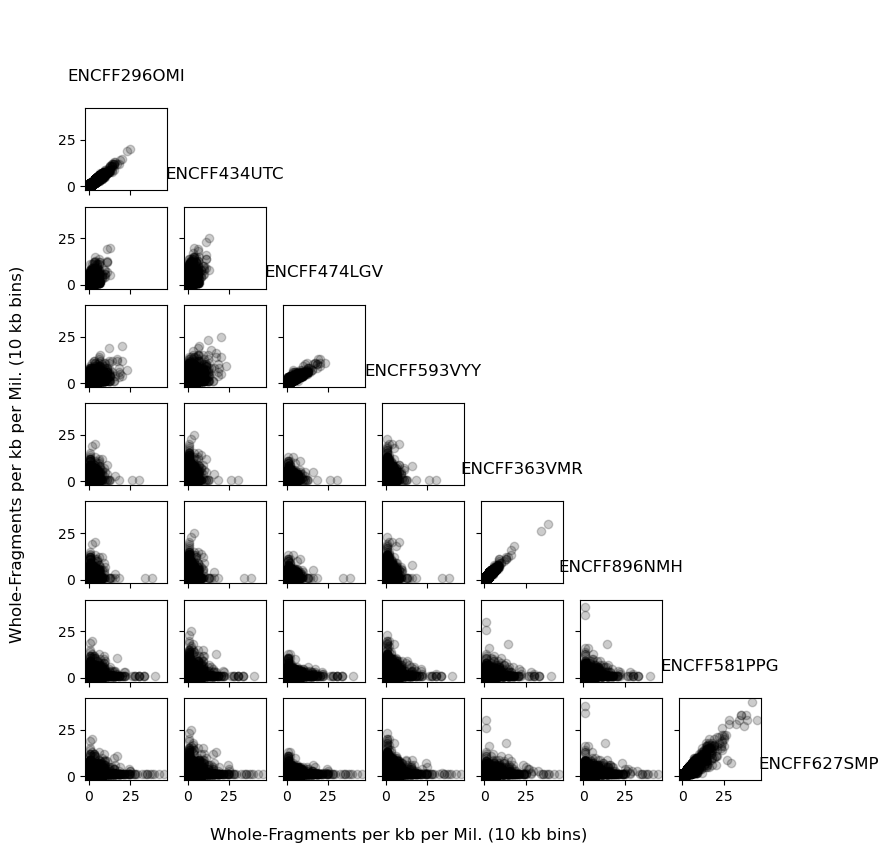

In [11]:
## Plot a corr grid of the bi-variate scatter plots 
f,a = epv.corrgrid(h3k27ac,samples[:8],xy=None)

In [12]:
## Initilize result
results = []

## Iterate thru the samples 
for i,si in enumerate(samples):
    for j,sj in enumerate(samples):
        
        ## If the row is larger than column 
        if i > j:
            ## Switch between true and false in co-zero removal 
            for cz in (True,False):
                ## Gather the x and y 
                x,y = h3k27ac[si].values,h3k27ac[sj].values
                
                ## Calculate pearson's R, R2, nmi, and spearman
                pr = sims.copearson(x,y,cozero=cz)
                r2 = pr**2
                mi = sims.conmi(x,y,cozero=cz)
                sp = sims.cospearman(x,y,cozero=cz)
                
                ## Calc a boolean to see if this comparison is a replicate
                isrep = (sj == repdict[si])
                
                ## Append the results
                results.append((si,sj,cz,isrep,pr,r2,mi,sp))

## Make results into a dataframe
results = pd.DataFrame(results,columns=['Sample1','Sample2','Cozero','Isrep','PearsonR','Rsquared','NMI','Spearman'])
            
## Show head
results.head()

,Sample1,Sample2,Cozero,Isrep,PearsonR,Rsquared,NMI,Spearman
0,ENCFF434UTC,ENCFF296OMI,True,True,0.918004,0.842732,0.608936,0.727863
1,ENCFF434UTC,ENCFF296OMI,False,True,0.942492,0.888292,0.820703,0.932781
2,ENCFF474LGV,ENCFF296OMI,True,False,0.443921,0.197066,0.165293,0.326666
3,ENCFF474LGV,ENCFF296OMI,False,False,0.728945,0.531361,0.603190,0.813700
4,ENCFF474LGV,ENCFF434UTC,True,False,0.438439,0.192229,0.165130,0.331266


In [13]:
## Set the order of the statistics to plot 
stats = ['Spearman','PearsonR','Rsquared','NMI']

## Set the stat lables, make sure the match above 
stat_labels = ['Spearman '+ '\u03C1', 'Pearson $R$', '$R^2$','Normalized Mutual Information']

## Form into a dictionary
stat_label_dict = dict(zip(stats,stat_labels))

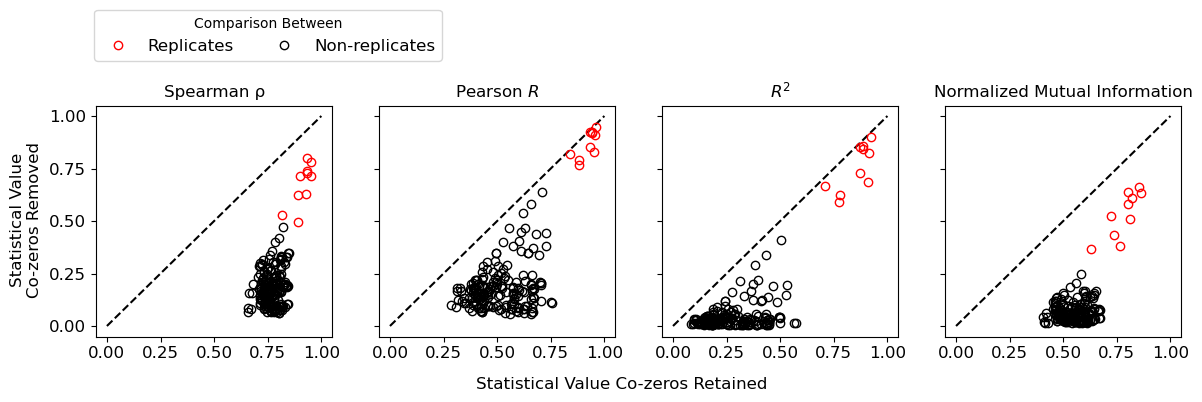

In [14]:
## Set the subplots, equal axis, with white background
fig,ax = plt.subplots(1,4,figsize=(14,3),sharex=True,sharey=True)
fig.set_facecolor('w')

for i,s in enumerate(stats):
    ## Set the axis 
    plt.sca(ax[i])
    
    ## Set the title
    plt.title(stat_label_dict[s],fontsize=12)
    
    ## Plot a one to one line
    plt.plot([0,1],[0,1],'k--')
    
    for b in (True,False):
        ## Gather the x and y 
        x = results[(results.Cozero==False) & (results.Isrep==b)][s].values
        y = results[(results.Cozero==True)  & (results.Isrep==b)][s].values
    
        ## Plot the results 
        plt.plot(x,y,'o',fillstyle='none',color='r' if b else 'k')
    
    ## Reset the x and y ticks
    plt.xticks(np.arange(0,1.25,0.25),fontsize=12)
    plt.yticks(np.arange(0,1.25,0.25),fontsize=12)
    
## SEt first axis 
plt.sca(ax[0])

## Add mock poitns for making a legend 
plt.plot(0.25,0.75,'o',fillstyle='none',color='r',label='Replicates')
plt.plot(0.25,0.75,'o',fillstyle='none',color='k',label='Non-replicates')

## Color over the points 
plt.plot(0.25,0.75,'o',color='w',ms=10)

## Call legend
plt.legend(bbox_to_anchor=(1.5,1.45),fontsize=12,title='Comparison Between',ncol=2)
    
## Annotate the x and y axis 
fig.text(x=0.075,y=0.5,s='Statistical Value\nCo-zeros Removed',fontsize=12,rotation=90,va='center',ha='center');
fig.text(x=0.5,y=-0.05,s='Statistical Value Co-zeros Retained',fontsize=12,rotation=0,va='center',ha='center');

In [15]:
## Saveout resluts 
results.to_csv('../DATA/H3K27ac_stats.csv',index=False)

In [16]:
## Read in the file 
with open('../DATA/H3K27ac.counts.txt','r') as infile:
    fragcounts = infile.readlines()
    infile.close()

## Write ftn to get bam name
def getbam(a):
    return a.split('/')[-1].split('.bam')[0]

## make into a tmp dataframe by zipping 
tmp = pd.DataFrame(list(zip([getbam(a) for a in fragcounts[::2]],[int(a) for a in fragcounts[1::2]])))
tmp.columns = ['Bam','Count']

## Add a filtereed boolean 
tmp['Filtered'] = [False if (i%2==0) else True for i in range(tmp.shape[0])]

## Take the unfilt counts 
pref = tmp[~(tmp.Filtered)].copy()
pref['Total Fragments'] = pref.Count

## Take the filte coutns 
filt = tmp[(tmp.Filtered)].copy()
filt['Filtered Fragments'] = filt.Count

## Calculate the max fpkms
maxes = h3k27ac[h3k27ac.columns[3:]].max()

## Format the max  df 
maxdf = pd.DataFrame(maxes).reset_index()
maxdf.columns = ['Bam','Max WFpkm (10 kb bins)']

## Gather the cell info for replicates 1 and 2
rep1in = cellinfo[['Cellline','Replicate1']]
rep2in = cellinfo[['Cellline','Replicate2']]

## Format into df
repin = pd.DataFrame(rep1in.values.tolist() + rep2in.values.tolist(),columns=['Cell Line','Bam'])

## merge results 
tmp = pref[['Bam','Total Fragments']].merge(filt[['Bam','Filtered Fragments']]).merge(maxdf).merge(repin)

## Set the assay type 
tmp['Assay'] = 'H3K27ac'

## Saveout the csv 
h3k4me = pd.read_csv('../DATA/H3K4me3.formated.counts.csv')

## Print to screen
h3k27ac_fc = pd.concat([tmp,h3k4me])

## Set the encode accession 
h3k27ac_fc['ENCODE Accession'] = h3k27ac_fc['Bam']

## Drop the bam name 
h3k27ac_fc.drop('Bam',axis=1,inplace=True)

## Reorder columns 
h3k27ac_fc = h3k27ac_fc[h3k27ac_fc.columns[::-1]]

## Make the column ints 
for c in h3k27ac_fc.columns[3:]:
    h3k27ac_fc[c] = h3k27ac_fc[c].apply(int)

## Save out the table 
h3k27ac_fc.to_csv('../TABLES/S.table.2.csv',index=False)

In [17]:
## Print to screen 
h3k27ac_fc.groupby('Assay').count()

,ENCODE Accession,Cell Line,Max WFpkm (10 kb bins),Filtered Fragments,Total Fragments
Assay,,,,,
H3K27ac,20,20,20,20,20
H3K4me3,10,10,10,10,10
